In [1]:
# Importation des librairies
from my_function import ( 
    sel_classif_pixel,
    report_from_dict_to_df,
    supprimer_dossier_non_vide)
import os
import matplotlib.pyplot as plt
from osgeo import gdal
import geopandas as gpd
import numpy as np
import pandas as pd
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
sys.path.append('/home/onyxia/work/libsigma')
import read_and_write as rw
import classification as cla
import plots

In [2]:
# Création du dossier de sauvegarde temporaire et paramètres
output_dir = "/home/onyxia/work/output_classif"
os.makedirs(output_dir, exist_ok=True) # Création d'un dossier output temporaire

sample_path = "/home/onyxia/work/Depot_Git/results/data/sample/Sample_BD_foret_T31TCJ.shp"
path_sample_px = os.path.join(output_dir,"sample_classif_px.shp")

sample_rasterized = os.path.join(output_dir,"rasterized_sample.tif")
path_image_3b = "/home/onyxia/work/Depot_Git/results/data/img_pretraitees/Serie_temp_S2_3_bands.tif"
path_image_10b = "/home/onyxia/work/Depot_Git/results/data/img_pretraitees/Serie_temp_S2_10_bands.tif"
path_image_allbands = "/home/onyxia/work/Depot_Git/results/data/img_pretraitees/Serie_temp_S2_allbands.tif"

path_sample_px_centroid = os.path.join(output_dir,"sample_px_centroid.shp")

In [3]:
# Save d'un vecteur echantillons avec que les données pour classif pixel
sample = gpd.read_file(sample_path)
sample_px = sel_classif_pixel(sample[['Code',"geometry"]])
sample_px.to_file(path_sample_px)

In [4]:
# cmd rasterisation paramètres
in_vector = os.path.join(output_dir,'sample_classif_px.shp')
ref_image = '/home/onyxia/work/Depot_Git/results/data/img_pretraitees/Serie_temp_S2_allbands.tif'
ref_image_open = rw.open_image(ref_image)
out_image = os.path.join(output_dir, "rasterized_sample.tif")
field_name = 'Code'  # field containing the numeric label of the classes
sptial_resolution = rw.get_pixel_size(ref_image_open)[0]
xmin,ymax = rw.get_origin_coordinates(ref_image_open)
y,x = rw.get_image_dimension(ref_image_open)[0:2]
xmax,ymin = xmin+x*10,ymax-y*10

# define command pattern to fill with paremeters
cmd_pattern = ("gdal_rasterize -a {field_name} "
               "-tr {sptial_resolution} {sptial_resolution} "
               "-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
               "{in_vector} {out_image}")

# fill the string with the parameter thanks to format function
cmd = cmd_pattern.format(in_vector=in_vector, xmin=xmin, ymin=ymin, xmax=xmax,
                         ymax=ymax, out_image=out_image, field_name=field_name,
                         sptial_resolution=sptial_resolution)

# execute the command in the terminal
os.system(cmd)

/opt/conda/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [ ]:
# Méthode stratifiée simple
# 1 --- define parameters
# inputs
sample_filename = sample_rasterized
image_filename = path_image_3b

# Sample parameters
#test_size = 0.7
nb_iter = 30
nb_folds = 5
is_point = False
# if is_point is True
field_name = 'Code'

# outputs
suffix = '_CV{}fold_stratifed_x{}times'.format(nb_folds, nb_iter)
out_folder = output_dir
out_classif = os.path.join(out_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(out_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(out_folder, 'mes_qualites{}.png'.format(suffix))

print("Extraction des échantillons")
# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

print("KFold début")
kf = StratifiedKFold(n_splits=nb_folds)
for train, test in kf.split(X, Y):
    print(train,test)
    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]

    print("Entrainement")
    # 3 --- Train
    rfc = RandomForestClassifier(
        max_depth = 50,
        oob_score = True,
        max_samples = 0.75,
        class_weight = 'balanced',
        n_jobs = -1
    )
    rfc.fit(X_train, Y_train[:,0])

    print("Predict")
    # 4 --- Test
    Y_predict = rfc.predict(X_test)

    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict,

                                   labels=np.unique(Y_predict), output_dict=True)

    # store them
    list_report.append(report_from_dict_to_df(report))

# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

In [5]:
# Méthode stratifiée groupée 

L = [i+1 for i in range(sample_px.shape[0])]  # Création des id de polygones
sample_px_id = sample_px.copy()
sample_px_id['id'] = L
sample_px_id = sample_px_id[['id','geometry']]
sample_px_id.to_file(os.path.join(output_dir,"sample_px_id.shp"))

# cmd rasterisation paramètres
in_vector = os.path.join(output_dir,"sample_px_id.shp")
ref_image = '/home/onyxia/work/Depot_Git/results/data/img_pretraitees/Serie_temp_S2_allbands.tif'
ref_image_open = rw.open_image(ref_image)
out_image = os.path.join(output_dir, "rasterized_sample_id.tif")
field_name = 'id'  # field containing the numeric label of the classes
sptial_resolution = rw.get_pixel_size(ref_image_open)[0]
xmin,ymax = rw.get_origin_coordinates(ref_image_open)
y,x = rw.get_image_dimension(ref_image_open)[0:2]
xmax,ymin = xmin+x*10,ymax-y*10

# define command pattern to fill with paremeters
cmd_pattern = ("gdal_rasterize -a {field_name} "
               "-tr {sptial_resolution} {sptial_resolution} "
               "-te {xmin} {ymin} {xmax} {ymax} -ot UInt16 -of GTiff "
               "{in_vector} {out_image}")

# fill the string with the parameter thanks to format function
cmd = cmd_pattern.format(in_vector=in_vector, xmin=xmin, ymin=ymin, xmax=xmax,
                         ymax=ymax, out_image=out_image, field_name=field_name,
                         sptial_resolution=sptial_resolution)

# execute the command in the terminal
os.system(cmd)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [6]:
# 1 --- define parameters
# inputs
sample_filename = sample_rasterized
image_filename = path_image_allbands
id_filename = os.path.join(output_dir, "rasterized_sample_id.tif")

# Sample parameters
#test_size = 0.7
nb_iter = 30
nb_folds = 5
is_point = False
# if is_point is True
field_name = 'Code'

# outputs
suffix = '_CV{}folds_stratified_group_x{}times'.format(nb_folds, nb_iter)
out_folder = "/home/onyxia/work"
out_classif = os.path.join(out_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(out_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(out_folder, 'mes_qualites{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
    _, groups, _ = cla.get_samples_from_roi(image_filename, id_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []
groups = np.squeeze(groups)

# Iter on stratified K fold
for i in range(nb_iter):
    print (f"Début de la {i+1} itération")
    kf = StratifiedGroupKFold(n_splits=nb_folds, shuffle=True)
    for train, test in kf.split(X, Y, groups=groups):
        X_train, X_test = X[train], X[test]
        Y_train, Y_test = Y[train], Y[test]

        # 3 --- Train
        rfc = RandomForestClassifier(
            max_depth = 50,
            oob_score = True,
            max_samples = 0.75,
            class_weight = 'balanced',
            n_jobs = -1
        )
        rfc.fit(X_train, Y_train[:,0])

        # 4 --- Test
        Y_predict = rfc.predict(X_test)

        # compute quality
        list_cm.append(confusion_matrix(Y_test, Y_predict))
        list_accuracy.append(accuracy_score(Y_test, Y_predict))
        report = classification_report(Y_test, Y_predict,
                                        labels=np.unique(Y_predict),
                                        output_dict=True,
                                        zero_division = 0)

        # store them
        list_report.append(report_from_dict_to_df(report))

Début de la 1 itération
{'11': {'precision': 0.5244604316546763, 'recall': 0.1833039979884335, 'f1-score': 0.27166014533258803, 'support': 11931.0}, '12': {'precision': 0.9423956497978416, 'recall': 0.9971256232215093, 'f1-score': 0.9689884433833036, 'support': 416786.0}, '13': {'precision': 0.8649885583524027, 'recall': 0.162825759207409, 'f1-score': 0.2740619902120718, 'support': 4643.0}, '14': {'precision': 0.6258938652615732, 'recall': 0.1783951941643424, 'f1-score': 0.27765255864429417, 'support': 9322.0}, '22': {'precision': 0.5639097744360902, 'recall': 0.3191489361702128, 'f1-score': 0.4076086956521739, 'support': 470.0}, '23': {'precision': 0.3324742268041237, 'recall': 0.1519434628975265, 'f1-score': 0.2085691188358933, 'support': 2547.0}, '24': {'precision': 0.8761793512444963, 'recall': 0.6642370572207085, 'f1-score': 0.7556278817466775, 'support': 14680.0}, '25': {'precision': 0.5875978326309452, 'recall': 0.45778611632270166, 'f1-score': 0.5146322172422885, 'support': 213

In [7]:
import json
list_dir = "/home/onyxia/work"

# Sauvegarder la liste dans un fichier JSON
# with open(os.path.join(list_dir,"list_cm.json"), "w", encoding="utf-8") as fichier:
#     json.dump(list_cm, fichier, indent=4, ensure_ascii=False)
# with open(os.path.join(list_dir,"list_accuracy.json"), "w", encoding="utf-8") as fichier:
#     json.dump(list_accuracy, fichier, indent=4, ensure_ascii=False)
list_json = [df.to_dict(orient="records") for df in list_report]
with open(os.path.join(list_dir,"list_report.json"), "w", encoding="utf-8") as fichier:
    json.dump(list_json, fichier, indent=4, ensure_ascii=False)

In [8]:
# Stratégie d'évitement : supprimer les tableaux qui n'ont pas toutes les classes
list_report_2 = []
list_cm_2 = []
for cm,report in zip(list_cm,list_report):
    nb_report = len(report.keys())
    nb_cm = len(cm)
    # print(nb_classes)
    if nb_report == 9 :
        list_report_2.append(report)
    if nb_cm == 9:
        list_cm_2.append(cm)

/home/onyxia/work/libsigma/plots.py:199: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)


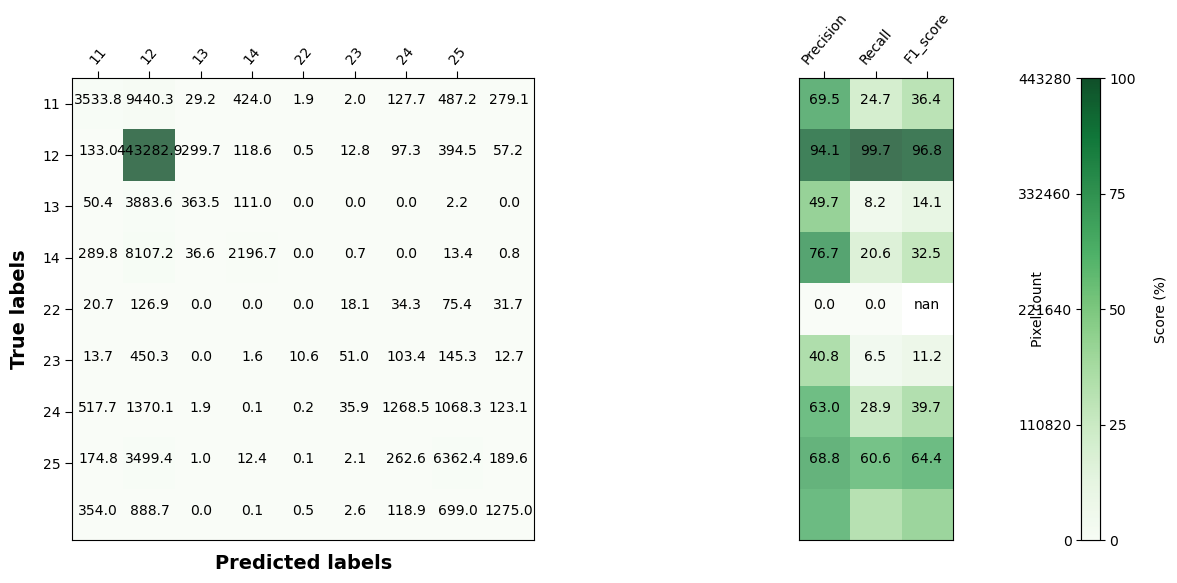

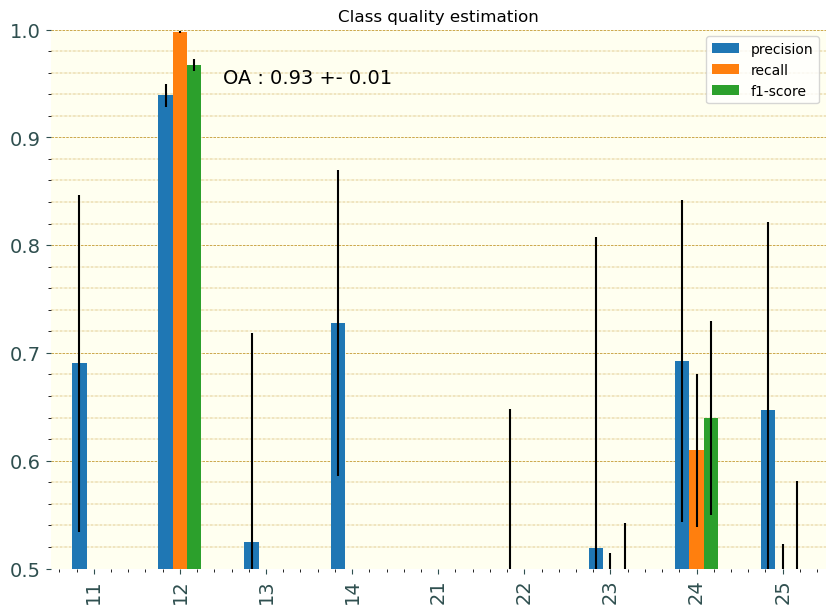

In [9]:
# compute mean of cm
array_cm = np.array(list_cm_2)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report_2)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

In [10]:
# Ecriture de la classif

X_img, _, t_img = cla.get_samples_from_roi(path_image_allbands, path_image_allbands)
Y_predict = rfc.predict(X_img)
image_filename = path_image_allbands

# Get image dimension
ds = rw.open_image(image_filename)
nb_row, nb_col, _ = rw.get_image_dimension(ds)

#initialization of the array
img = np.zeros((nb_row, nb_col, 1), dtype='uint8')
#np.Y_predict

img[t_img[0], t_img[1], 0] = Y_predict
image_filename =path_image_allbands

out_filename = '/home/onyxia/work/Depot_Git/results/data/classif/carte_essences_echelle_pixel.tif'

# get reference dataset
ds = rw.open_image(image_filename)

# just replace the number of band (1 instead of 3)
rw.write_image(out_filename, img, data_set=ds, gdal_dtype=gdal.GDT_Byte,
                transform=None, projection=None, driver_name=None,
                nb_col=None, nb_ligne=None, nb_band=1)

In [38]:
## Nettoyage des dossiers
supprimer_dossier_non_vide(output_dir)